In [70]:
from __future__ import print_function    # (at top of module)
import warnings
warnings.filterwarnings('always')
from spotipy.oauth2 import SpotifyClientCredentials
import json
import spotipy
import time
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
from matplotlib.pyplot import figure
import math
import seaborn as sns
import io, os, sys, types

In [71]:
# Read the data from the file
data = pd.read_csv('Data/data_500_entries_youtube.csv')
print("Number of entries in original data: " + str(len(data.index)))
data.head()

Number of entries in original data: 570


,song_id,song_title,artist,popularity,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration,loudness,valence,mode,youtube_view_count,youtube_video_title
0,spotify:track:5ygDXis42ncn6kYG14lEVG,Baby Shark,[Pinkfong],77,0.840,0.3410,115.062,0.2270,0.2450,0.000000,4,0.825,7,96333,-3.651,0.520,1,1956582159,Baby Shark Dance | Sing and Dance! | Animal So...
1,spotify:track:7fa9MBXhVfQ8P8Df9OEbD8,Girls Like You (feat. Cardi B),"[Maroon 5, Cardi B]",86,0.541,0.1300,124.959,0.0505,0.5680,0.000000,4,0.851,0,235545,-6.825,0.448,1,1300452389,Maroon 5 - Girls Like You ft. Cardi B
2,spotify:track:6De0lHrwBfPfrhorm9q1Xl,Me Rehúso,[Danny Ocean],83,0.804,0.0494,104.823,0.0677,0.0231,0.000000,4,0.744,1,205715,-6.327,0.426,1,1229501096,Danny Ocean - Me Rehúso (Official Audio)
3,spotify:track:1j6xOGusnyXq3l6IryKF3G,Déjala Que Vuelva (feat. Manuel Turizo),"[Piso 21, Manuel Turizo]",74,0.788,0.0753,170.019,0.0785,0.0482,0.000000,4,0.681,1,220117,-4.323,0.839,1,1216075058,Piso 21 - Déjala Que Vuelva (feat. Manuel Turi...
4,spotify:track:2ijef6ni2amuunRoKTlgww,Sin Pijama,"[Becky G, Natti Natasha]",90,0.745,0.1040,94.014,0.0464,0.3540,0.000029,4,0.791,11,188560,-3.695,0.820,0,1071141995,Becky G Natti Natasha - Sin Pijama (Video Ofic...


In [72]:
if 'song_id' in data.columns:
    data = data.drop_duplicates(subset=['song_id'], keep='first')
else:
    data = data.drop_duplicates(subset=['song_title'], keep='first')
    
print("Number of entries in original data after cleaning: " + str(len(data.index)))

Number of entries in original data after cleaning: 570


In [73]:
data = data[data.total_no_streams > 10000000]
print("Number of entries in original data after cleaning: " + str(len(data.index)))

AttributeError: 'DataFrame' object has no attribute 'total_no_streams'

In [74]:
from project_modules import *

#final_data = label_data_combined(data, 90, 1000000000)
final_data = label_data(data, 89)

Number of popular examples after thresholding :  55
Number of not popular examples after thresholding :  515


In [75]:
# Drop unnecessary columns from original data - also some legacy support for a different data format
if 'song_id' in data.columns:
    final_data.drop(['song_id', 'song_title', 'artist', 'popularity', 'youtube_view_count', 'youtube_video_title'], 1, inplace=True)
else:
    final_data.drop(['song_title', 'artist', 'popularity'], 1, inplace=True) 

In [76]:
COLUMNS_TO_SCALE = ["energy", "liveness", "tempo", 
                    "speechiness", "acousticness", "instrumentalness", 
                    "time_signature", "danceability", "key", 
                    "duration", "loudness", "valence", "mode"]
#COLUMNS_TO_SCALE = ["energy", "tempo","loudness", "valence"]

# Keep data in a temp variable for testing
scaled_data = scale_data_standardize(final_data, COLUMNS_TO_SCALE)

# Plots to see the difference before/after scaling
# plt.subplot(1,2,1)
# plt.plot(data['duration'])
# plt.title("Duration before scaling")

# plt.subplot(1,2,2)
# plt.plot(scaled_data['duration'])
# plt.title("Duration after scaling")
# plt.tight_layout()
# plt.show()

# Copy data back
final_data = scaled_data.copy()

#Just to check that everything is fine
final_data.head()

C:\Users\Rares\Desktop\3YP-WORK\python\project_modules.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  scaled_data[columns] = scale(scaled_data[columns])


,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration,loudness,valence,mode,is_popular
0,1.134405,1.053202,-0.263119,0.898741,-0.028242,-0.144642,0.060474,0.935711,0.496241,-2.711681,1.099652,-0.006954,0.862044,0
1,-0.725307,-0.307878,0.073383,-0.747680,1.378645,-0.144642,0.060474,1.133659,-1.458350,0.839454,-0.346005,-0.342110,0.862044,0
2,0.910493,-0.827797,-0.611250,-0.587236,-0.994769,-0.144642,0.060474,0.319027,-1.179123,0.078526,-0.119182,-0.444518,0.862044,0
3,0.810977,-0.660726,1.605444,-0.486492,-0.885441,-0.144642,0.060474,-0.160616,-1.179123,0.445904,0.793577,1.477973,0.862044,0
4,0.543526,-0.475594,-0.978761,-0.785926,0.446528,-0.144238,0.060474,0.676856,1.613150,-0.359078,1.079611,1.389529,-1.160034,1


In [77]:
# X will be our examples and y will be our labels
X = final_data.drop('is_popular', axis=1)
y = final_data['is_popular']
# Sanity checks
print("Number of entries in actual data: " + str(len(X.index)))
print("Number of entries in label data: " + str(len(y.index)))

Number of entries in actual data: 570
Number of entries in label data: 570


In [78]:
# We split the data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=5)
print("Items in training data set : ", str(len(X_train.index)))
print("Items in testing data set: ", str(len(X_test.index)))

Items in training data set :  285
Items in testing data set:  285


In [104]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# models = [
#           {'title':"Gaussian Naive Bayes", 'model':GaussianNB(), 'feature_set':'all'},
#           {'title':"Logistic regression", 'model':LogisticRegression(solver='lbfgs', random_state=3), 'feature_set':'all'},
#           {'title':"Logistic regression balanced weights", 'model':LogisticRegression(solver='lbfgs',class_weight='balanced', random_state=3), 'feature_set':['energy', 'tempo', 'instrumentalness', 'danceability', 'loudness', 'valence']},
#           {'title':"Oversampling logistic regression", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(solver='lbfgs',random_state=3)), 'feature_set':['energy', 'danceability', 'loudness', 'valence']},
#           {'title':"Oversampling logistic regression balanced weights", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(solver='lbfgs',class_weight='balanced',random_state=3)), 'feature_set':'all'},
#           {'title':"KNN", 'model':KNeighborsClassifier(n_neighbors = 1), 'feature_set':'all'},
#           {'title':"Oversampling KNN", 'model':make_pipeline_imb(SMOTE(random_state=4), KNeighborsClassifier(n_neighbors = 1)), 'feature_set':['energy', 'liveness', 'acousticness', 'instrumentalness', 'danceability', 'loudness', 'valence']},
#           {'title':"SVM", 'model':svm.SVC(probability=True, gamma='scale', random_state=3), 'feature_set':'all'},
#           {'title':"SVM balanced weights", 'model':svm.SVC(probability=True, gamma='scale', random_state=3, class_weight='balanced'), 'feature_set':'all'},#['energy', 'tempo', 'acousticness', 'danceability', 'loudness', 'valence']},
#           {'title':"Oversampling SVM", 'model':make_pipeline_imb(SMOTE(random_state=4), svm.SVC(probability=True, gamma='scale', random_state=3)), 'feature_set':['energy', 'tempo', 'speechiness', 'loudness', 'valence']},
#           {'title':"Multilayer Perceptron", 'model':MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=3), 'feature_set':['energy', 'tempo', 'key', 'duration', 'loudness', 'valence']},
#           {'title':"Oversampling Multilayer Perceptron", 'model':make_pipeline_imb(SMOTE(random_state=4), MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=3)), 'feature_set':['energy', 'tempo', 'time_signature', 'duration', 'loudness', 'valence']},
#           {'title':"Random Forest Classifier balanced weights", 'model':RandomForestClassifier(n_estimators=100, max_depth=2, random_state=3, class_weight="balanced"), 'feature_set':['liveness', 'acousticness', 'instrumentalness', 'time_signature', 'danceability', 'duration', 'valence', 'mode']},
#           {'title':"AdaBoost", 'model':AdaBoostClassifier(n_estimators=100), 'feature_set':'all'}
#          ]
models = [
          {'title':"Gaussian Naive Bayes", 'model':GaussianNB(), 'feature_set':'all'},
          {'title':"Logistic regression", 'model':LogisticRegression(solver='lbfgs', random_state=3), 'feature_set':'all'},
          {'title':"Logistic regression balanced weights", 'model':LogisticRegression(solver='lbfgs',class_weight='balanced', random_state=3), 'feature_set':'all'},
          {'title':"Oversampling logistic regression", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(solver='lbfgs',random_state=3)), 'feature_set':'all'},
          {'title':"Oversampling logistic regression balanced weights", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(solver='lbfgs',class_weight='balanced',random_state=3)), 'feature_set':'all'},
          {'title':"KNN", 'model':KNeighborsClassifier(n_neighbors = 17), 'feature_set':'all'},
          {'title':"Oversampling KNN", 'model':make_pipeline_imb(SMOTE(random_state=4), KNeighborsClassifier(n_neighbors = 17)), 'feature_set':'all'},
          {'title':"SVM", 'model':svm.SVC(probability=True, gamma='scale', random_state=3), 'feature_set':'all'},
          {'title':"SVM balanced weights", 'model':svm.SVC(probability=True, gamma='scale', random_state=3, class_weight='balanced'), 'feature_set':'all'},
          {'title':"Oversampling SVM", 'model':make_pipeline_imb(SMOTE(random_state=4), svm.SVC(probability=True, gamma='scale', random_state=3)), 'feature_set':'all'},
          {'title':"Multilayer Perceptron", 'model':MLPClassifier(activation = 'relu', solver='lbfgs', alpha=1, hidden_layer_sizes=(5, 2), random_state=3), 'feature_set':'all'},
          {'title':"Oversampling Multilayer Perceptron", 'model':make_pipeline_imb(SMOTE(random_state=4), MLPClassifier(activation = 'relu', solver='lbfgs', alpha=1, hidden_layer_sizes=(5, 2), random_state=3)), 'feature_set':'all'},
          {'title':"Random Forest Classifier balanced weights", 'model':RandomForestClassifier(n_estimators=100, max_depth=13, random_state=3, class_weight="balanced"), 'feature_set':'all'},
          {'title':"AdaBoost", 'model':AdaBoostClassifier(n_estimators=100), 'feature_set':'all'}
         ]
stats_columns = ["Model title", "Accuracy", "Specificity", "Recall(Sensitivity)", "Precision", "F1", "AUC"]

Gaussian Naive Bayes
[0.         0.02439024 0.34146341 0.34146341 0.36585366 0.36585366
 0.3902439  0.3902439  0.43902439 0.43902439 0.73170732 0.73170732
 1.        ]
[0.  0.  0.  0.2 0.2 0.4 0.4 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.02439024 0.19512195 0.19512195 0.31707317 0.31707317
 0.43902439 0.43902439 0.46341463 0.46341463 0.48780488 0.48780488
 0.95121951 1.        ]
[0.  0.  0.  0.2 0.2 0.4 0.4 0.6 0.6 0.8 0.8 1.  1.  1. ]
[0.         0.         0.         0.07317073 0.07317073 0.26829268
 0.26829268 0.92682927 0.92682927 1.        ]
[0.  0.2 0.4 0.4 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.02439024 0.3902439  0.3902439  0.43902439 0.43902439
 0.53658537 0.53658537 1.        ]
[0.  0.  0.  0.2 0.2 0.6 0.6 1.  1. ]
[0.         0.02439024 0.31707317 0.31707317 0.41463415 0.41463415
 0.53658537 0.53658537 0.63414634 0.63414634 1.        ]
[0.  0.  0.  0.4 0.4 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.02439024 0.24390244 0.24390244 0.36585366 0.36585366
 0.56097561 0.56097561 0.85365

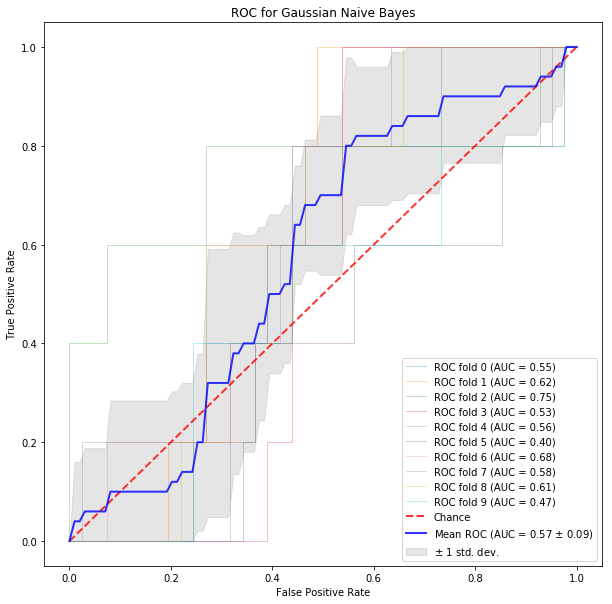

Accuracy mean:  0.3652173913043478

Logistic regression
[0.         0.02439024 0.07317073 0.07317073 0.19512195 0.19512195
 0.3902439  0.3902439  0.48780488 0.48780488 0.80487805 0.80487805
 1.        ]
[0.  0.  0.  0.2 0.2 0.4 0.4 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.02439024 0.14634146 0.14634146 0.19512195 0.19512195
 0.2195122  0.2195122  0.46341463 0.46341463 1.        ]
[0.  0.  0.  0.2 0.2 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.02439024 0.02439024 0.04878049 0.04878049 0.2195122
 0.2195122  1.        ]
[0.  0.  0.2 0.2 0.8 0.8 1.  1. ]
[0.         0.02439024 0.02439024 0.29268293 0.29268293 0.34146341
 0.34146341 0.43902439 0.43902439 1.        ]
[0.  0.  0.2 0.2 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.02439024 0.07317073 0.07317073 0.2195122  0.2195122
 0.26829268 0.26829268 0.75609756 0.75609756 1.        ]
[0.  0.  0.  0.2 0.2 0.4 0.4 0.6 0.6 1.  1. ]
[0.         0.02439024 0.04878049 0.04878049 0.07317073 0.07317073
 0.19512195 0.19512195 0.51219512 0.51219512 1.         1.

C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classificatio

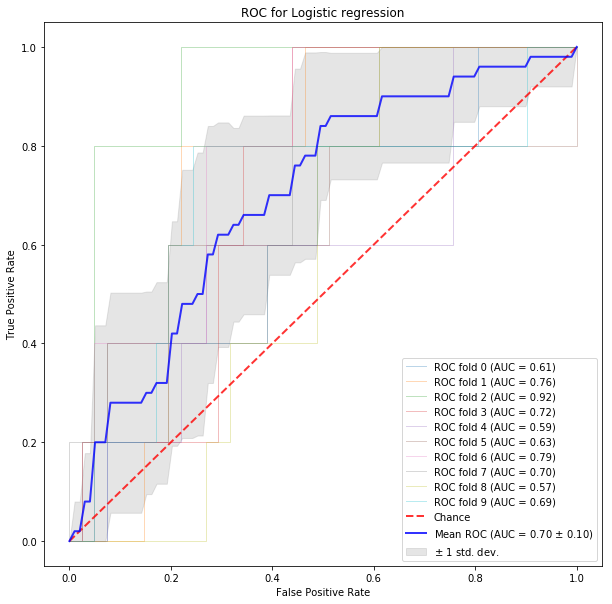

Accuracy mean:  0.8891304347826086

Logistic regression balanced weights
[0.         0.02439024 0.07317073 0.07317073 0.17073171 0.17073171
 0.31707317 0.31707317 0.48780488 0.48780488 0.68292683 0.68292683
 1.        ]
[0.  0.  0.  0.2 0.2 0.4 0.4 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.02439024 0.14634146 0.14634146 0.2195122  0.2195122
 0.41463415 0.41463415 1.        ]
[0.  0.  0.  0.2 0.2 0.8 0.8 1.  1. ]
[0.         0.02439024 0.02439024 0.04878049 0.04878049 0.14634146
 0.14634146 0.26829268 0.26829268 1.        ]
[0.  0.  0.2 0.2 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.02439024 0.07317073 0.07317073 0.2195122  0.2195122
 0.26829268 0.26829268 0.34146341 0.34146341 0.43902439 0.43902439
 1.        ]
[0.  0.  0.  0.2 0.2 0.4 0.4 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.02439024 0.04878049 0.04878049 0.26829268 0.26829268
 0.65853659 0.65853659 0.70731707 0.70731707 1.        ]
[0.  0.  0.  0.2 0.2 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.02439024 0.02439024 0.14634146 0.14634146 0.3658

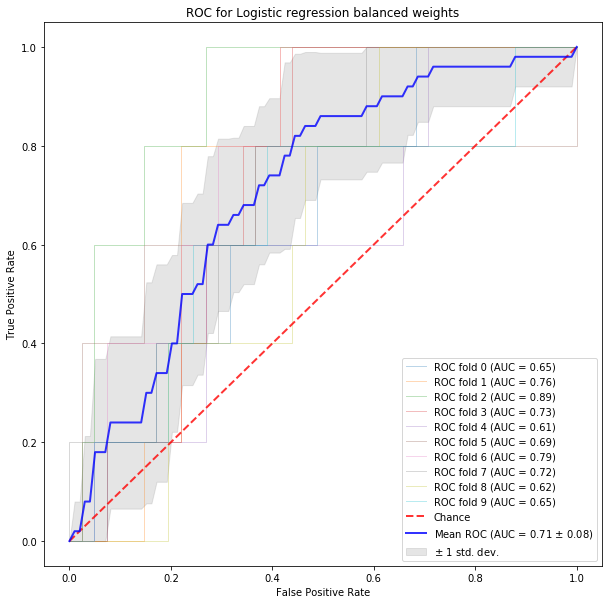

Accuracy mean:  0.6108695652173913

Oversampling logistic regression
[0.         0.02439024 0.07317073 0.07317073 0.24390244 0.24390244
 0.36585366 0.36585366 0.43902439 0.43902439 0.80487805 0.80487805
 1.        ]
[0.  0.  0.  0.2 0.2 0.4 0.4 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.02439024 0.17073171 0.17073171 0.19512195 0.19512195
 0.24390244 0.24390244 0.70731707 0.70731707 1.        ]
[0.  0.  0.  0.2 0.2 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.         0.07317073 0.07317073 0.09756098 0.09756098
 0.17073171 0.17073171 0.29268293 0.29268293 1.        ]
[0.  0.2 0.2 0.4 0.4 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.02439024 0.04878049 0.04878049 0.24390244 0.24390244
 0.26829268 0.26829268 0.36585366 0.36585366 1.        ]
[0.  0.  0.  0.2 0.2 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.02439024 0.09756098 0.09756098 0.2195122  0.2195122
 0.51219512 0.51219512 0.68292683 0.68292683 1.        ]
[0.  0.  0.  0.2 0.2 0.4 0.4 0.6 0.6 1.  1. ]
[0.         0.         0.04878049 0.04878049 0.1463

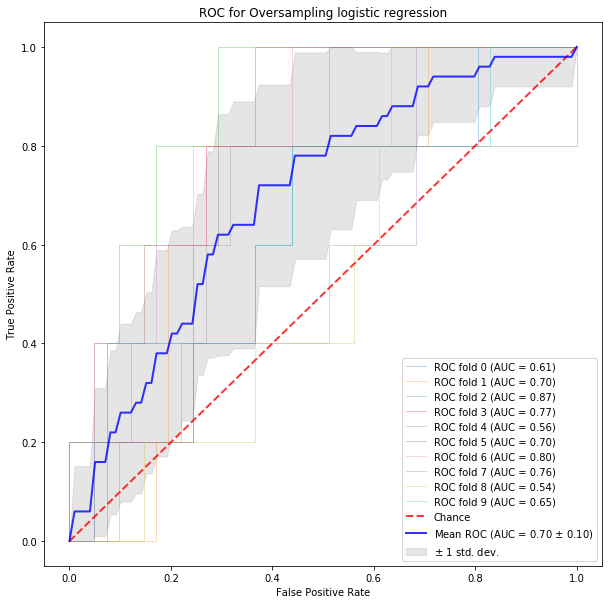

Accuracy mean:  0.6195652173913044

Oversampling logistic regression balanced weights
[0.         0.02439024 0.07317073 0.07317073 0.24390244 0.24390244
 0.36585366 0.36585366 0.43902439 0.43902439 0.80487805 0.80487805
 1.        ]
[0.  0.  0.  0.2 0.2 0.4 0.4 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.02439024 0.17073171 0.17073171 0.19512195 0.19512195
 0.24390244 0.24390244 0.70731707 0.70731707 1.        ]
[0.  0.  0.  0.2 0.2 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.         0.07317073 0.07317073 0.09756098 0.09756098
 0.17073171 0.17073171 0.29268293 0.29268293 1.        ]
[0.  0.2 0.2 0.4 0.4 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.02439024 0.04878049 0.04878049 0.24390244 0.24390244
 0.26829268 0.26829268 0.36585366 0.36585366 1.        ]
[0.  0.  0.  0.2 0.2 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.02439024 0.09756098 0.09756098 0.2195122  0.2195122
 0.51219512 0.51219512 0.68292683 0.68292683 1.        ]
[0.  0.  0.  0.2 0.2 0.4 0.4 0.6 0.6 1.  1. ]
[0.         0.         0.04878049 

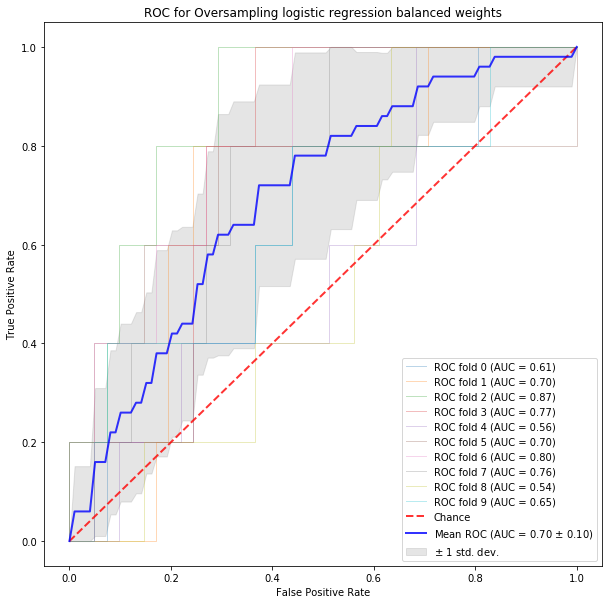

Accuracy mean:  0.6195652173913044

KNN
[0.         0.12195122 0.17073171 0.3902439  0.63414634 0.85365854
 1.        ]
[0.  0.  0.2 0.4 0.6 1.  1. ]
[0.         0.04878049 0.17073171 0.41463415 0.56097561 0.85365854
 1.        ]
[0.  0.2 0.4 0.8 1.  1.  1. ]
[0.         0.02439024 0.07317073 0.19512195 0.36585366 0.56097561
 0.87804878 1.        ]
[0.  0.  0.  0.4 0.4 1.  1.  1. ]
[0.         0.02439024 0.14634146 0.26829268 0.58536585 0.7804878
 1.        ]
[0.  0.2 0.4 1.  1.  1.  1. ]
[0.         0.02439024 0.12195122 0.24390244 0.3902439  0.51219512
 0.80487805 1.        ]
[0.  0.  0.  0.2 0.4 0.6 0.8 1. ]
[0.         0.07317073 0.19512195 0.34146341 0.6097561  0.87804878
 1.        ]
[0.  0.2 0.6 0.6 0.8 0.8 1. ]
[0.         0.09756098 0.14634146 0.24390244 0.48780488 0.85365854
 1.        ]
[0.  0.2 0.2 0.4 1.  1.  1. ]
[0.         0.02439024 0.04878049 0.14634146 0.46341463 0.68292683
 1.        ]
[0.  0.  0.2 0.6 0.8 1.  1. ]
[0.         0.02439024 0.04878049 0.29268293 0.5121

C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classificatio

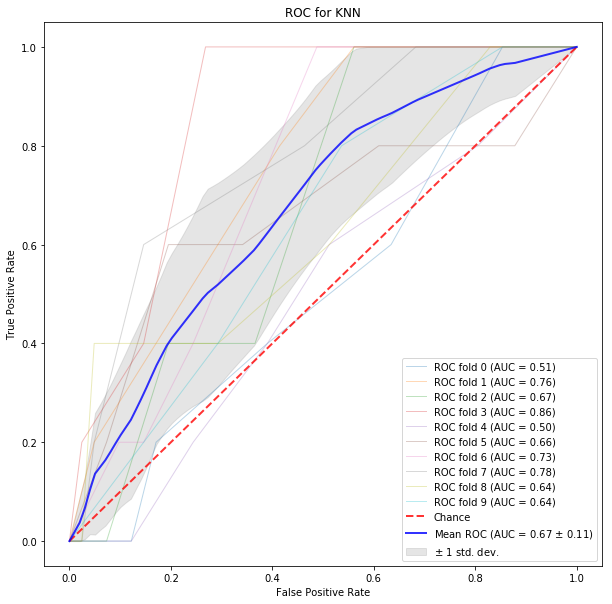

Accuracy mean:  0.8913043478260867

Oversampling KNN
[0.         0.04878049 0.09756098 0.17073171 0.2195122  0.34146341
 0.41463415 0.51219512 0.58536585 0.63414634 0.75609756 0.80487805
 0.87804878 0.90243902 1.        ]
[0.  0.  0.  0.  0.4 0.4 0.6 0.6 0.8 1.  1.  1.  1.  1.  1. ]
[0.         0.02439024 0.04878049 0.17073171 0.19512195 0.2195122
 0.29268293 0.34146341 0.46341463 0.6097561  0.75609756 0.85365854
 0.90243902 1.        ]
[0.  0.  0.2 0.2 0.2 0.4 0.8 0.8 1.  1.  1.  1.  1.  1. ]
[0.         0.04878049 0.24390244 0.34146341 0.3902439  0.46341463
 0.56097561 0.70731707 0.92682927 0.95121951 1.        ]
[0.  0.  0.  0.8 0.8 1.  1.  1.  1.  1.  1. ]
[0.         0.02439024 0.02439024 0.19512195 0.19512195 0.29268293
 0.36585366 0.41463415 0.53658537 0.68292683 0.80487805 0.95121951
 1.        ]
[0.  0.  0.2 0.2 0.4 0.6 0.6 0.8 1.  1.  1.  1.  1. ]
[0.         0.04878049 0.07317073 0.17073171 0.2195122  0.26829268
 0.3902439  0.41463415 0.43902439 0.51219512 0.56097561 0.63414

KeyboardInterrupt: 

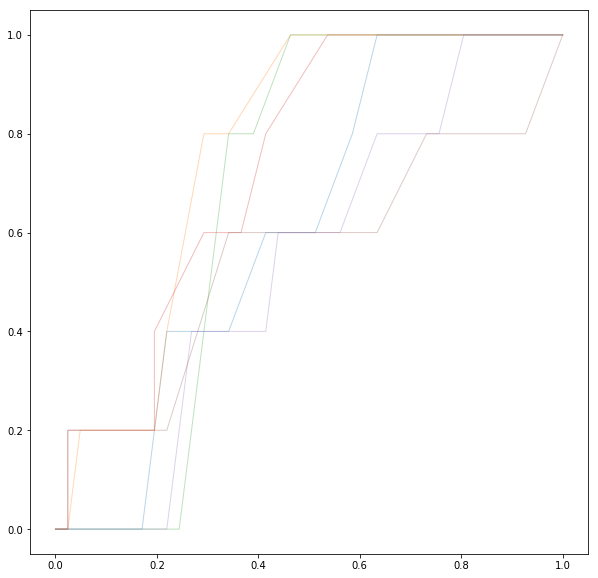

In [107]:
from sklearn import svm, datasets
from itertools import cycle
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
stats_columns = ["Model title", "Accuracy", "Specificity", "Recall(Sensitivity)", "Precision", "F1", "AUC", "Generalized AUC"]
#X = np.array(X)
#y = np.array(y)
cv = StratifiedShuffleSplit(n_splits=10, random_state=5)
cv_stats = []
X_fs, X_test, y_fs, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

#print(X_fs.head())

for item in models:
    # Run classifier with cross-validation and plot ROC curves
    print(item['title'])
    classifier = item['model']
    tprs = []
    aucs = []
    accs = []
    specificities = []
    recalls = []
    precisions = []
    f1s = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    cur_feature_set=item['feature_set']
    if(cur_feature_set == 'all'):
        X_cfs=np.array(X_fs)
        cur_feature_set= COLUMNS_TO_SCALE
    else:
        X_cfs=np.array(X_fs[cur_feature_set])
    y_fs = np.array(y_fs)
#     print(X_cfs.head())
    for train, test in cv.split(X_cfs, y_fs):
        probas_ = classifier.fit(X_cfs[train], y_fs[train]).predict_proba(X_cfs[test])
        predicts = classifier.predict(X_cfs[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_fs[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        conf_matrix = confusion_matrix(y_fs[test], predicts)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        accs.append(accuracy_score(y_fs[test], predicts))
        specificities.append(float(conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[0][1]))
        recalls.append(recall_score(y_fs[test], predicts))
        precisions.append(precision_score(y_fs[test], predicts))
        f1s.append(f1_score(y_fs[test], predicts, average='weighted'))
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + item['title'])
    plt.legend(loc="lower right")
    plt.show()

    print("Accuracy mean: ",np.mean(accs))
    print()
    item['model'].fit(X_cfs, y_fs)
    y_pred_prob = item['model'].predict_proba(X_test[cur_feature_set])[:,1]
    test_after_auc = roc_auc_score(y_test, y_pred_prob)
    newRow = [item['title'],np.mean(accs), np.mean(specificities), np.mean(recalls), np.mean(precisions), np.mean(f1s), mean_auc, test_after_auc]
    cv_stats.append(newRow)
stats_df = pd.DataFrame(cv_stats, columns = stats_columns)
stats_df

# Gridsearch 

In [90]:
# this code is from http://www.davidsbatista.net/blog/2018/02/23/model_optimization/
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV

class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=10, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [93]:
# models = [
#           {'title':"Logistic regression", 'model':LogisticRegression(random_state=3), 'feature_set':['liveness', 'tempo', 'acousticness', 'danceability', 'key', 'duration']},
#           {'title':"Logistic regression balanced weights", 'model':LogisticRegression(class_weight='balanced', random_state=3), 'feature_set':['tempo', 'acousticness', 'danceability', 'valence']},
#           {'title':"Oversampling logistic regression", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(random_state=3)), 'feature_set':['tempo', 'acousticness', 'danceability', 'key', 'valence']},
#           {'title':"Oversampling logistic regression balanced weights", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(class_weight='balanced',random_state=3)), 'feature_set':['tempo', 'acousticness', 'danceability', 'key', 'valence']},
#           {'title':"KNN", 'model':KNeighborsClassifier(n_neighbors = 17), 'feature_set':['liveness', 'tempo', 'acousticness', 'danceability']},
#           {'title':"Oversampling KNN", 'model':make_pipeline_imb(SMOTE(random_state=4), KNeighborsClassifier(n_neighbors = 17)), 'feature_set':['energy', 'instrumentalness', 'duration', 'valence', 'mode']},
#           {'title':"SVM", 'model':svm.SVC(probability=True, gamma='scale', random_state=3), 'feature_set':['liveness', 'tempo', 'acousticness', 'danceability', 'loudness', 'mode']},
#           {'title':"SVM balanced weights", 'model':svm.SVC(probability=True, gamma='scale', random_state=3, class_weight='balanced'), 'feature_set':['speechiness', 'key']},
#           {'title':"Oversampling SVM", 'model':make_pipeline_imb(SMOTE(random_state=4), svm.SVC(probability=True, gamma='scale', random_state=3)), 'feature_set':['tempo', 'time_signature']},
#           {'title':"Multilayer Perceptron", 'model':MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=3), 'feature_set':['energy', 'acousticness', 'danceability', 'duration', 'valence', 'mode']},
#           {'title':"Oversampling Multilayer Perceptron", 'model':make_pipeline_imb(SMOTE(random_state=4), MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=3)), 'feature_set':['loudness', 'speechiness']},
#           {'title':"Random Forest Classifier balanced weights", 'model':RandomForestClassifier(n_estimators=100, max_depth=2, random_state=3, class_weight="balanced"), 'feature_set':['loudness', 'speechiness']}
#          ]

models1 = { 
    "KNN":KNeighborsClassifier(),
    'Logistic regression': LogisticRegression(class_weight='balanced', random_state=3),
    'SVM balanced weights': svm.SVC(random_state=3, class_weight='balanced'),
    'Multilayer Perceptron': MLPClassifier(random_state=3),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100, max_depth=2, random_state=3, class_weight="balanced")
}

params1 = { 
    'KNN':{'n_neighbors':[1,3,5,7,9,11,13,15,17, 19, 21]},
    'Logistic regression': { 'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                             'C' : [0.001, 0.0001, 0.0001, 0.01, 0.1, 1]},
    'SVM balanced weights': { 'kernel' : ['rbf', 'linear', 'poly', 'sigmoid'], 
                              'gamma' : ['auto', 'scale'], 
                              'decision_function_shape' : ['ovo', 'ovr'], 
                              'C' : [0.001, 0.0001, 0.0001, 0.01, 0.1, 1]},
    'Multilayer Perceptron': { 'activation' : ['identity', 'logistic', 'tanh', 'relu'], 
                               'solver' : ['lbfgs', 'sgd', 'adam'], 
                               'alpha' : [1e-5, 1e-4, 1, 1e-3, 1e-2], 
                               'learning_rate' : ['constant', 'invscaling', 'adaptive']},
    'Random Forest Classifier':{ 'n_estimators' : [10, 100, 200, 500, 1000], 
                                 'max_depth': [2, 5, 7, 10, 13], 
                                 'criterion' : ['gini', 'entropy']}
}

In [94]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X, y, scoring='roc_auc', n_jobs=10, refit=True)
helper1.score_summary(sort_by='mean_score')


Running GridSearchCV for KNN.
Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  91 out of 110 | elapsed:    5.9s remaining:    1.1s
[Parallel(n_jobs=10)]: Done 110 out of 110 | elapsed:    6.0s finished
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Running GridSearchCV for Logistic regression.
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed:    1.0s finished
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Running GridSearchCV for SVM balanced weights.
Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 620 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done 960 out of 960 | elapsed:    5.6s finished
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Running GridSearchCV for Multilayer Perceptron.
Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=10)]: Done  80 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done 361 tasks      | elapsed:   17.5s
[Parallel(n_jobs=10)]: Done 611 tasks      | elapsed:   31.6s
[Parallel(n_jobs=10)]: Done 961 tasks      | elapsed:   59.1s
[Parallel(n_jobs=10)]: Done 1411 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 1800 out of 1800 | elapsed:  2.3min finished
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Running GridSearchCV for Random Forest Classifier.
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   24.7s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:  1.4min finished
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


KNN
Logistic regression
SVM balanced weights
Multilayer Perceptron
Random Forest Classifier


C:\Users\Rares\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,estimator,min_score,mean_score,max_score,std_score,C,activation,alpha,criterion,decision_function_shape,gamma,kernel,learning_rate,max_depth,n_estimators,n_neighbors,solver
290,Multilayer Perceptron,0.509804,0.690818,0.843137,0.0947895,NaN,relu,1,NaN,NaN,NaN,NaN,constant,NaN,NaN,NaN,lbfgs
293,Multilayer Perceptron,0.509804,0.690818,0.843137,0.0947895,NaN,relu,1,NaN,NaN,NaN,NaN,invscaling,NaN,NaN,NaN,lbfgs
296,Multilayer Perceptron,0.509804,0.690818,0.843137,0.0947895,NaN,relu,1,NaN,NaN,NaN,NaN,adaptive,NaN,NaN,NaN,lbfgs
133,SVM balanced weights,0.533333,0.689272,0.827451,0.101961,1,NaN,NaN,NaN,ovr,scale,rbf,NaN,NaN,NaN,NaN,NaN
125,SVM balanced weights,0.533333,0.689272,0.827451,0.101961,1,NaN,NaN,NaN,ovo,scale,rbf,NaN,NaN,NaN,NaN,NaN
129,SVM balanced weights,0.537255,0.68888,0.823529,0.100322,1,NaN,NaN,NaN,ovr,auto,rbf,NaN,NaN,NaN,NaN,NaN
121,SVM balanced weights,0.537255,0.68888,0.823529,0.100322,1,NaN,NaN,NaN,ovo,auto,rbf,NaN,NaN,NaN,NaN,NaN
305,Multilayer Perceptron,0.505882,0.674498,0.815686,0.0868188,NaN,relu,0.001,NaN,NaN,NaN,NaN,adaptive,NaN,NaN,NaN,lbfgs
299,Multilayer Perceptron,0.505882,0.674498,0.815686,0.0868188,NaN,relu,0.001,NaN,NaN,NaN,NaN,constant,NaN,NaN,NaN,lbfgs
302,Multilayer Perceptron,0.505882,0.674498,0.815686,0.0868188,NaN,relu,0.001,NaN,NaN,NaN,NaN,invscaling,NaN,NaN,NaN,lbfgs


In [98]:
helper1.score_summary(sort_by='mean_score').to_csv("scores.csv")

KNN
Logistic regression
SVM balanced weights
Multilayer Perceptron
Random Forest Classifier


C:\Users\Rares\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

